#### **Project: Risk Parity Model in Chinese Stock Market**
##### *Author: Xiangyuan Mo; *
##### *Full Code & Description on GitHub:https://github.com/RUC-Tree/Quantitative-Research*
##### **Brief Introduction:**
The Risk Parity Model is an investment portfolio construction method that aims to achieve diversified asset allocation and risk diversification by equalizing the risk contributions of each asset. The model was formally proposed by Edward Qian, CIO of PanAgora, and Bridgewater's "All Weather Strategy" is an application of the risk parity concept.

##### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import scipy.optimize as sco
import scipy.interpolate as sci
%matplotlib inline

##### 2. Data Import and Visualization

In [2]:
def load_and_process_data(file_path):
    """Load and preprocess the data in a CSV file.
    Parameters: file_path (str): path to the CSV file; Returns: pd.DataFrame: the processed DataFrame. """
    df = pd.read_csv(file_path) # Ingest CSV
    df['TradeDate'] = pd.to_datetime(df['TradeDate']) # Convert 'TradeDate' column to datetime type
    df = df.set_index('TradeDate') # Set the 'TradeDate' column as an index
    scaled_data = df / df.iloc[0] * 100 # Scale Data
    return df, scaled_data

def plot_scaled_data(df):
    """Plot portfolio data (Use scaled data)."""
    sns.set(palette="muted") # Set Seaborn Style
    plt.plot(df, label=df.name, alpha=.6)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False # Set the display

def plot_heatmap(df):
    """ Plot portfolio correlation heatmap. """
    returns_df = (df-df.shift(1))/df.shift(1) # Calculate yield rate
    returns_df.dropna(axis='index', inplace=True) # Delete empty lines
    corr = returns_df.corr()
    plt.figure(figsize=(3, 2))  
    corr_heatmap = sns.heatmap(corr, cmap="YlGnBu", linewidths=.2, annot=True, annot_kws={"size": 5}, cbar_kws={"shrink": 0.8})
    plt.show()

In [3]:
file_path = r"C:\Users\mo_xi\Desktop\data_8assets.csv" # File location
df,scaled_data = load_and_process_data(file_path)
df.head(2)

,000300.SH,000852.SH,000832.CSI,HSTECH.HI,NDX.GI,SPX.GI,AU.SHF,IMCI.SHF
TradeDate,,,,,,,,
2015-01-05,3641.54,6049.79,457.45,3007.64,4160.96,2020.58,242.15,2588.66
2015-01-06,3641.06,6172.39,459.68,3002.18,4110.83,2002.61,244.45,2574.39


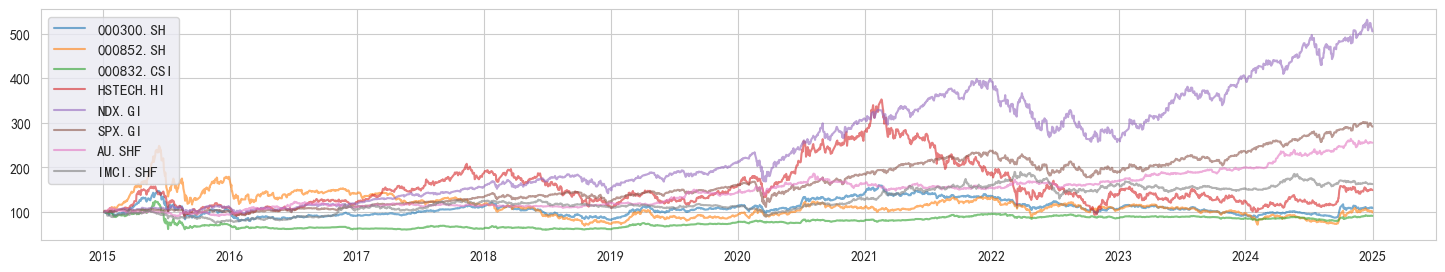

In [4]:
# Plot index data
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 1, figsize=(18, 3))
scaled_data.apply(plot_scaled_data)
plt.legend() 
plt.show()

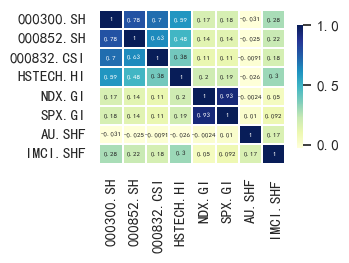

In [5]:
plot_heatmap(df) # Plot heatmap
#It can be found that the correlation between assets is not all very high, 
#which provides the basis for our application of risk parity model

##### 3. Modeling
Define Risk Contribution: $RC_i = w_i \frac{(\Sigma w)_i}{\sqrt{w^T \Sigma w}},$ 
  $w$ : Asset weight vector  $,\Sigma$ : Asset covariance matrix.

Objective function under risk parity: 
$min \sum_{i=1}^{n} \sum_{j=1}^{n} [RC_i-RC_j]^2,$
subject to $\sum_{i=1}^{n}w_i =1, ~~ 0\le w_i \le 1$

Which equals to: $min \sum_{i=1}^{n}[RC_i - \frac{1}{n} \sigma_p ]^2,$  $\sigma_p$ : Portfolio risk (volatility)


In [6]:
def calculate_cov_matrix(df):
    """calculate asset covariance matrix"""
    df = df/df.iloc[0]*100 # scale data
    returns_df = (df-df.shift(1))/df.shift(1) # Calculate yield rate
    returns_df.dropna(axis='index', inplace=True) 
    one_cov_matrix = returns_df.cov()*240
    return np.matrix(one_cov_matrix)
    
def calculate_risk_contribution(weight,one_cov_matrix):
    """calculate risk contribution"""
    weight=np.matrix(weight) 
    sigma=np.sqrt(weight*one_cov_matrix*weight.T)
    MRC=one_cov_matrix*weight.T/sigma # Marginal Risk Contribution (MRC)
    RC=np.multiply(MRC,weight.T) # Risk Contribution (RC)
    return RC

def naive_risk_parity(weight,parameters): 
    """Objective Function
    weight:The weight of the asset to be solved,
    parameters[0]: covariance matrix, parameters[1]: target RC vector under risk parity"""
    one_cov_matrix=parameters[0]
    RC_target_ratio=parameters[1] 
    sigma_portfolio=np.sqrt(weight*one_cov_matrix*np.matrix(weight).T) # portfolio risk
    RC_target=np.asmatrix(np.multiply(sigma_portfolio,RC_target_ratio))  # target RC
    RC_real=calculate_risk_contribution(weight,one_cov_matrix)  # real RC after iteration
    sum_squared_error= sum(np.square(RC_real-RC_target.T))[0,0] 
    return sum_squared_error 

def calculate_portfolio_weight(df,one_cov_matrix,risk_budget_objective):
    """calculate optimal weights"""
    num = df.shape[1]
    x0 = np.array([1.0 / num for _ in range(num)]) # set initial weights
    bounds = tuple((0, 1) for _ in range(num))     # set range (0,1)
    cons_1 = ({'type': 'eq', 'fun': lambda x: sum(x) - 1},)   # sum of weights should equal to 1
    RC_set_ratio = np.array([1.0 / num for _ in range(num)])   # set equal RC
    optv = sco.minimize(risk_budget_objective, x0, args=[one_cov_matrix,RC_set_ratio], method='SLSQP', bounds=bounds, constraints=cons_1)
    return optv.x

##### 4. Strategy
Weights are adjusted monthly, based on data from the previous 120 trading days

In [7]:
def get_train_set(change_time,df):
    """get previous 120 trading days data
    change_time: time to adjust the weights"""
    df = df.loc[df.index<change_time] 
    df = df.iloc[-120:] # previous 120 days data
    return df 

def get_weight_matrix(df):
    """get optimal weight matrix"""
    period_type = 'ME' # adjust weights monthly
    df_weight= df.resample(period_type).last() # monthly data
    df_weight = df_weight[df_weight.index>='2015-6-30'] #Ensure access to data from the previous 120 trading days       
    for i in range(len(df_weight.index)):
        change_time = df_weight.index[i]
        train_set = get_train_set(change_time,df) #get previous 120 trading days data
        one_cov_matrix = calculate_cov_matrix(train_set)
        df_weight.iloc[i] = calculate_portfolio_weight(train_set,one_cov_matrix,naive_risk_parity)
    return df_weight

def plot_weight_distribution(df):
    """Draw a stack diagram of the weight distribution"""
    for i in range(df.shape[0]):
        df.iloc[i] = df.iloc[i] / df.iloc[i].sum()
    labels = df.columns.to_list()
    fig, ax = plt.subplots(figsize=(12,3))
    plt.title('Risk Parity Model Weight Distribution')
    plt.yticks(np.arange(0, 1, step=0.2))
    ax.stackplot(df.index, df.T, baseline='zero', labels=labels)
    ax.legend(loc='upper left')
    plt.show()

In [8]:
df_weight_rp = get_weight_matrix(df)

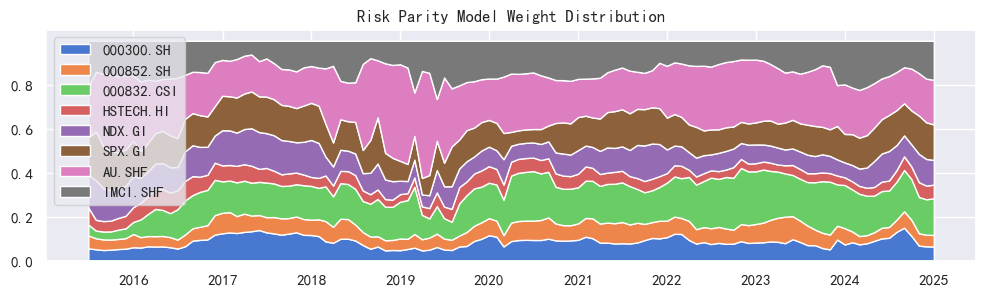

In [9]:
plot_weight_distribution(df_weight_rp)

##### 5. Validation

In [10]:
data = df[df.index>'2015-6-30'] # weight calculation begins at July,2015
scaled_data = data / data.iloc[0]*100 # scale data
# Assign monthly weights to each day for easy calculation
df_weight_rp_new = df_weight_rp.reindex(scaled_data.index, method='ffill') 

In [11]:
df_weight_rp_new

,000300.SH,000852.SH,000832.CSI,HSTECH.HI,NDX.GI,SPX.GI,AU.SHF,IMCI.SHF
TradeDate,,,,,,,,
2015-07-01,0.056539,0.058599,0.049615,0.077482,0.147602,0.171639,0.231057,0.207468
2015-07-02,0.056539,0.058599,0.049615,0.077482,0.147602,0.171639,0.231057,0.207468
2015-07-03,0.056539,0.058599,0.049615,0.077482,0.147602,0.171639,0.231057,0.207468
2015-07-06,0.056539,0.058599,0.049615,0.077482,0.147602,0.171639,0.231057,0.207468
2015-07-07,0.056539,0.058599,0.049615,0.077482,0.147602,0.171639,0.231057,0.207468
...,...,...,...,...,...,...,...,...
2024-12-25,0.065837,0.052634,0.161206,0.062181,0.121057,0.166452,0.198510,0.172124
2024-12-26,0.065837,0.052634,0.161206,0.062181,0.121057,0.166452,0.198510,0.172124
2024-12-27,0.065837,0.052634,0.161206,0.062181,0.121057,0.166452,0.198510,0.172124


In [12]:
# calculate RP portfolio value & Equal-Weight portfolio value
RP_portfolio_value = (df_weight_rp_new * scaled_data).sum(axis=1)
equal_weights = pd.Series(1 / len(df_weight_rp_new.columns), index=df_weight_rp_new.columns)
EW_portfolio_value = (scaled_data * equal_weights).sum(axis=1)

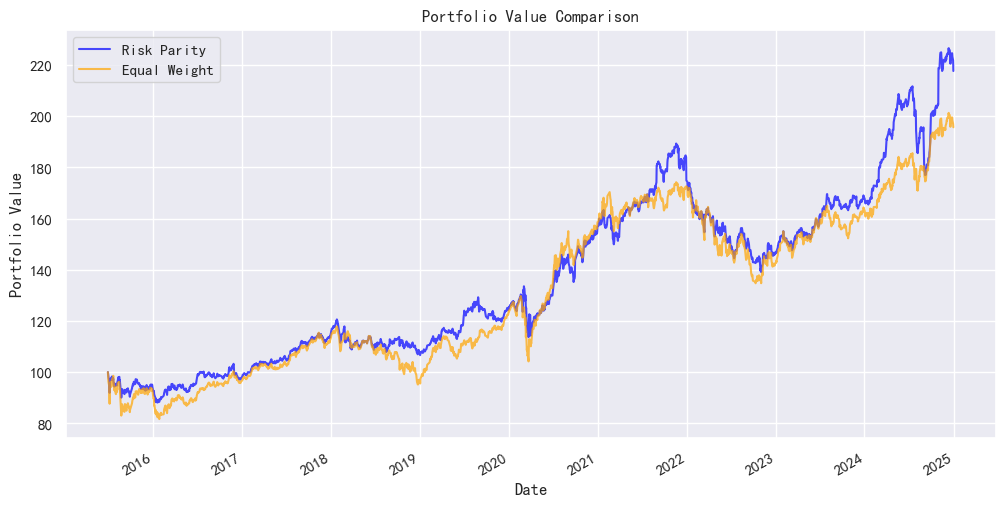

In [13]:
plt.figure(figsize=(12, 6))
RP_portfolio_value.plot(label="Risk Parity", color="blue", alpha=0.7)
EW_portfolio_value.plot(label="Equal Weight", color="orange", alpha=0.7)
plt.title("Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

##### Conclusion
##### It seems that RP model has some advantages over EW model...(Need further Exploration)